## Importing Libraries

In [1044]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from graphviz import Digraph

## Loading the Data

In [1045]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [1046]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

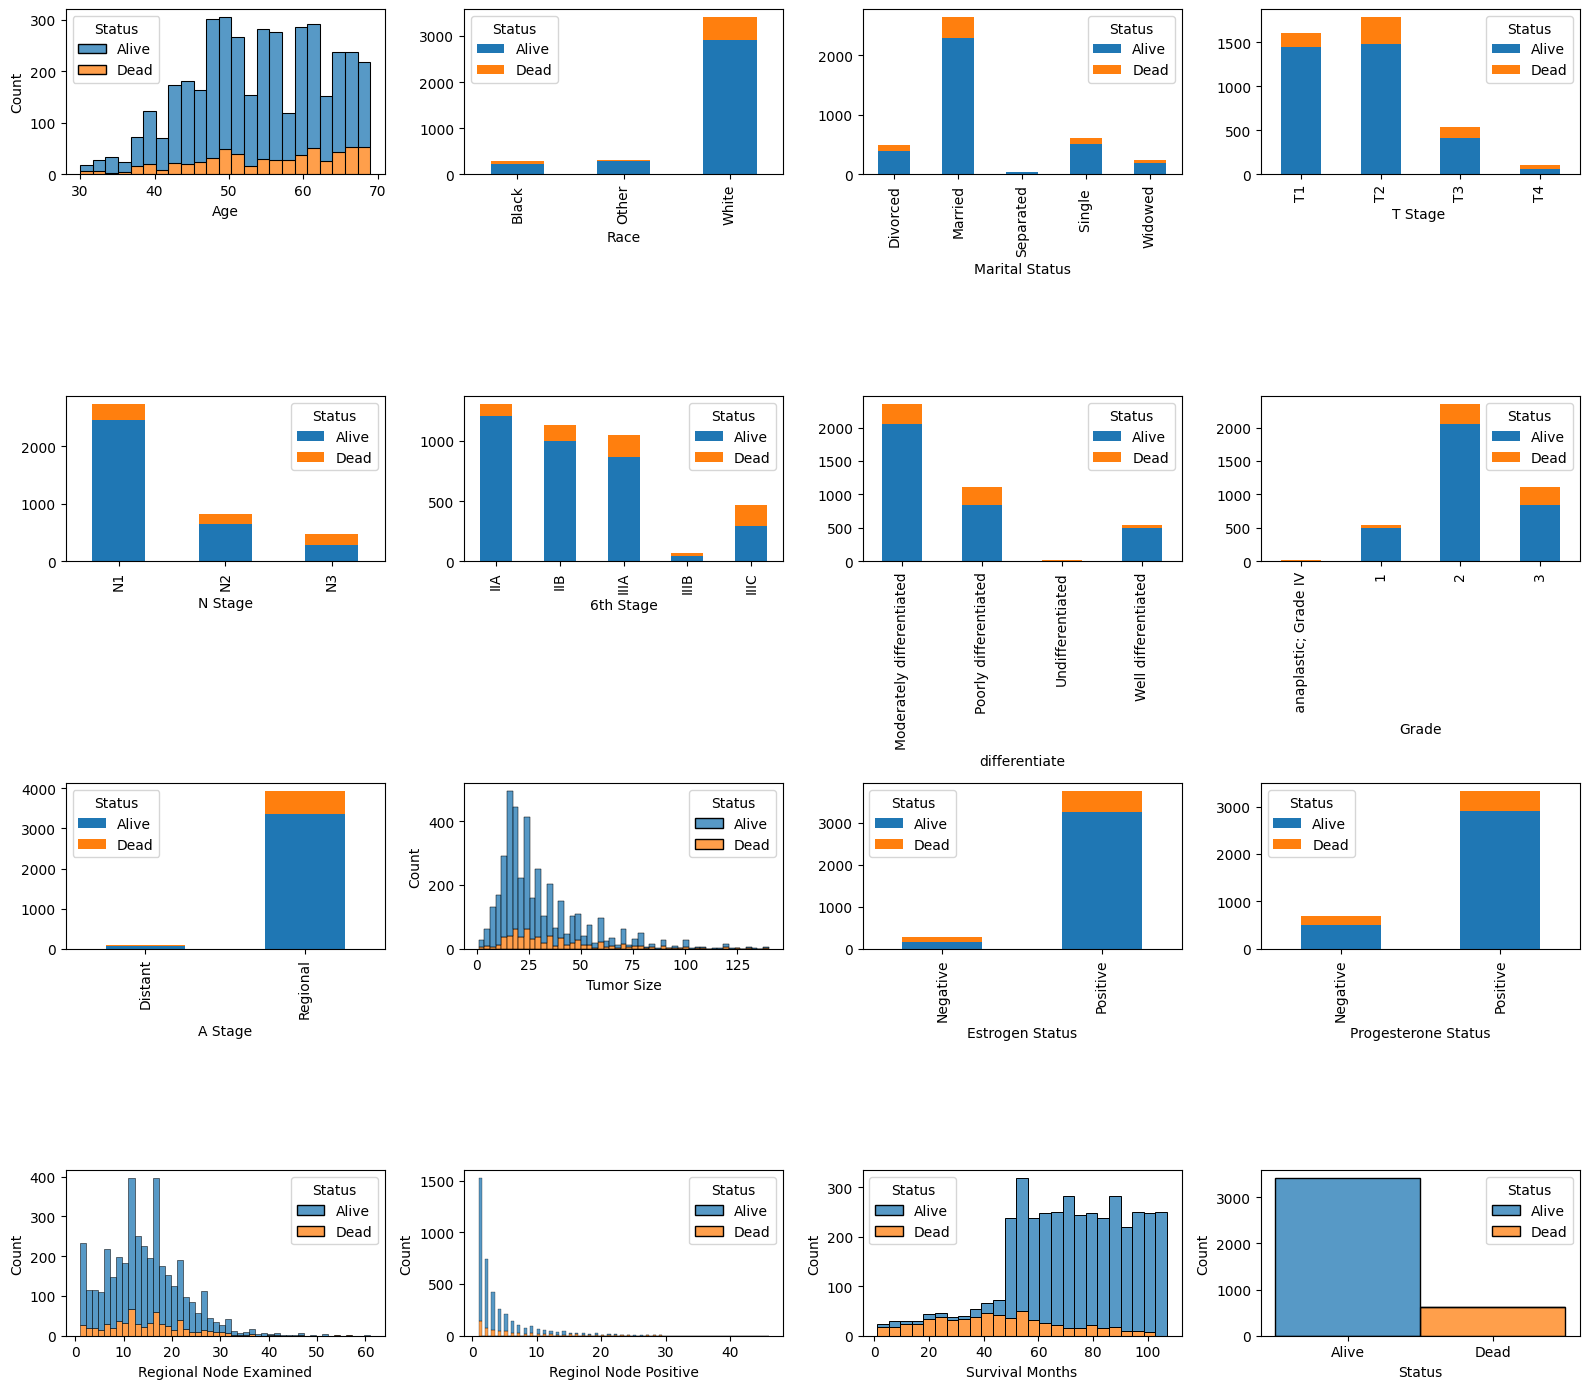

In [1047]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

<Axes: >

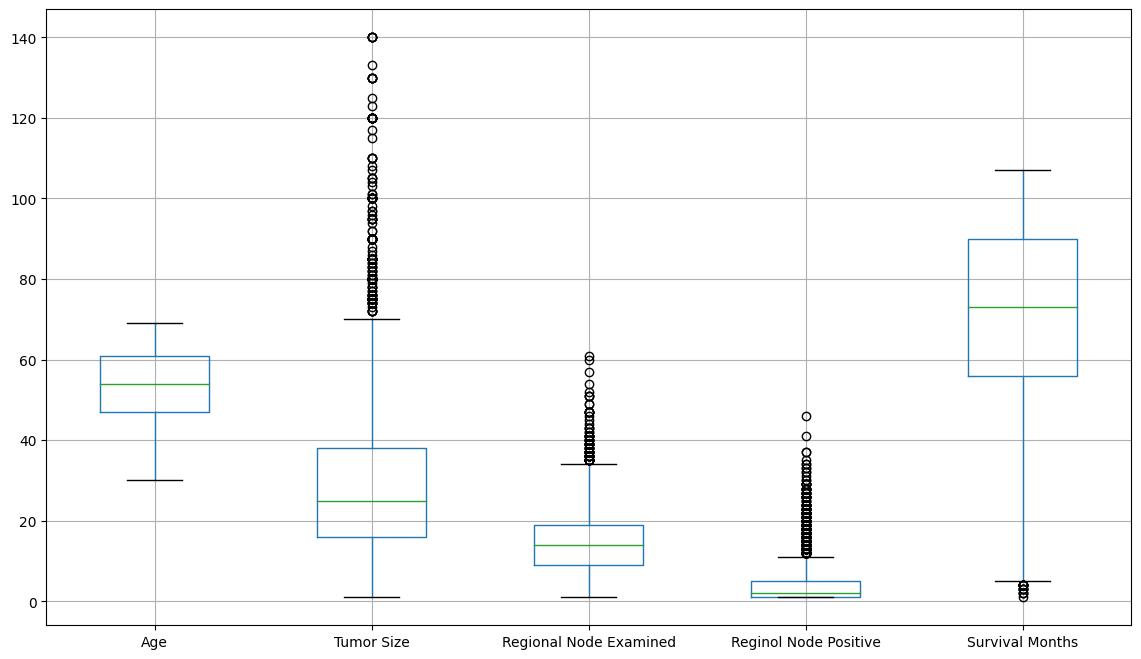

In [1048]:
df.loc[:,numerical_cols].boxplot(figsize=(14,8))

## Transformations

<Axes: ylabel='Frequency'>

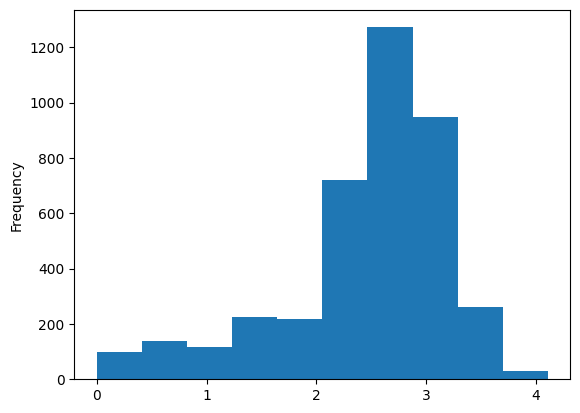

In [1049]:
df['Regional Node Examined'] = df['Regional Node Examined'].apply('log')
df['Regional Node Examined'].plot.hist()


<Axes: ylabel='Frequency'>

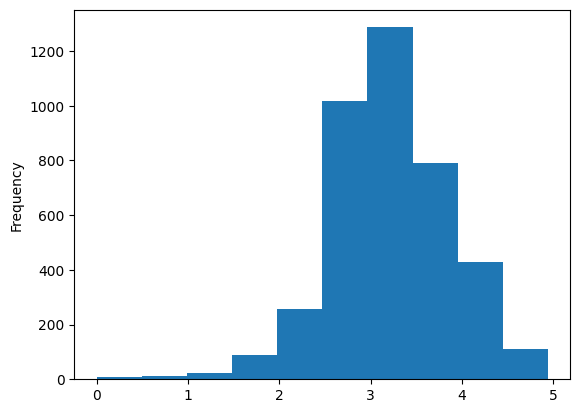

In [1050]:
df['Tumor Size'] = df['Tumor Size'].apply('log')
df['Tumor Size'].plot.hist()

## Train Test Split

In [1051]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Outlier Detection

<Axes: ylabel='Frequency'>

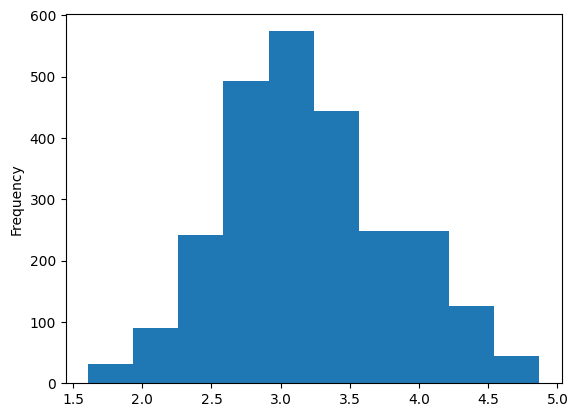

In [1052]:
# Calculate the IQR range
Q1 = X_train['Tumor Size'].quantile(0.25)
Q3 = X_train['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = (X_train['Tumor Size'] < lower_bound) | (X_train['Tumor Size'] > upper_bound)

# Remove outliers from 'Tumor Size'
X_train = X_train[~outliers_tumor_size]
y_train = y_train[~outliers_tumor_size]

X_train['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

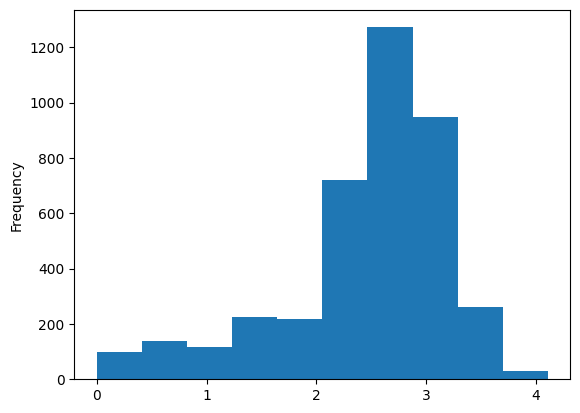

In [1053]:
# Calculate the IQR range
Q1 = X_train['Regional Node Examined'].quantile(0.25)
Q3 = X_train['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = (X_train['Regional Node Examined'] < lower_bound) | (X_train['Regional Node Examined'] > upper_bound)

# Remove outliers from 'Regional Node Examined'
X_train = X_train[~outliers_regional_node]
y_train = y_train[~outliers_regional_node]

df['Regional Node Examined'].plot.hist()

## Preprocessing

In [1054]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)
X_train.head()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Black,Race_Other,Race_White,Marital Status_Divorced,Marital Status_Married,...,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
844,0.794872,0.393154,0.479625,0.000000,0.924528,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,1
1993,0.256410,0.375611,0.293145,0.000000,0.471698,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,1
270,0.102564,0.762687,0.507318,0.177778,0.367925,0,0,1,0,1,...,0,0,1,0,1,0,0,1,0,1
1359,0.076923,0.268706,0.507318,0.022222,0.698113,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,1
2157,0.410256,0.831176,0.449521,0.022222,0.481132,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,1


## Data Balancing

In [1055]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2006, 1: 368})


In [1056]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1638, 0: 1337})


## Support Functions

In [1057]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [1058]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

def graphMLP(vars,layers,intercepts):
    """
    Function for plotting the weights of a mlp
    """
    f = Digraph('')
    f.attr(rankdir='LR')
    for i,l in enumerate(layers):
        if i==0:
            for j in range(l.shape[1]):
                for k, v in enumerate(vars):
                    f.edge(v, 'L%dN%d'%(i,j), label=str(l[k,j]))
            f.node('ILI', shape='doublecircle')                    
            for k in range(intercepts[i].shape[0]): 
                f.edge('ILI', 
                       'L%dN%d'%(i,k), 
                       label=str(intercepts[i][k]))
        else:
            for j in range(l.shape[1]):
                for k in range(layers[i-1].shape[1]):
                    f.edge('L%dN%d'%(i-1,k), 
                           'L%dN%d'%(i,j), 
                           label=str(l[k,j]))
            f.node('L%dI'%(i-1), shape='doublecircle')                  
            for k in range(intercepts[i].shape[0]):
                f.edge('L%dI'%(i-1), 
                       'L%dN%d'%(i,k), 
                       label=str(intercepts[i][k]))    
                
    return f


## LDA

In [1059]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.840062,0.569038,0.485714,0.686869,0.397661


In [1060]:
# Confusion matrix
confusion(y_val, y_pred_lda)

predicted,0,1
target,,
0,473,72
1,31,68


In [1061]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.545943,0
1,-0.735511,0
2,-2.513643,0
3,-0.837402,0
4,-1.640039,0
...,...,...
2970,2.577288,1
2971,2.598755,1
2972,2.545049,1
2973,2.504771,1


<Axes: xlabel='0'>

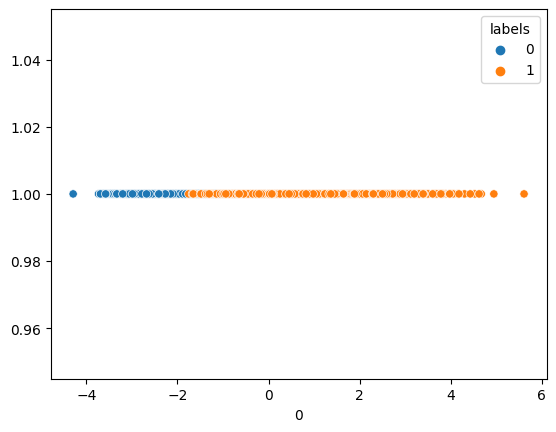

In [1062]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [1063]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   5   0.687888  0.417391  0.292683  0.727273  0.263736
      15  0.689441  0.415205  0.292181  0.717172  0.261993
      35  0.689441  0.415205  0.292181  0.717172  0.261993
      47  0.669255  0.396601  0.275591  0.707071   0.24735
      43  0.678571  0.403458  0.282258  0.707071  0.252708
      41  0.669255  0.396601  0.275591  0.707071   0.24735
      17  0.690994  0.412979  0.291667  0.707071  0.260223
      19  0.686335  0.409357  0.288066  0.707071  0.257353
      21  0.680124  0.404624  0.283401  0.707071  0.253623
      23  0.684783  0.408163  0.286885  0.707071   0.25641
      1   0.742236  0.453947  0.336585   0.69697  0.293617
      29  0.703416  0.419453       0.3   0.69697  0.265385
      45  0.680124  0.401163  0.281633   0.69697  0.250909
      31  0.695652  0.413174  0.293617   0.69697  0.260377
      25  0.690994  0.409496  0.289916   0.69697  0.2574

In [1064]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df.sort_values(by='Recall', ascending=False)

k value of the first row: 5


,Accuracy,F1,Precision,Recall,Jaccard
KNN-5,0.687888,0.417391,0.292683,0.727273,0.263736
LDA,0.840062,0.569038,0.485714,0.686869,0.397661


In [1065]:
# Confusion matrix
confusion(y_val, y_pred_knn)

predicted,0,1
target,,
0,371,174
1,27,72


## Logistic Regression

In [1066]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.768634  0.514658  0.379808   0.79798  0.346491
       1.0       0.801242  0.532847  0.417143  0.737374  0.363184
       100000.0  0.801242  0.503876  0.408805  0.656566  0.336788
       10000.0   0.801242  0.503876  0.408805  0.656566  0.336788
       1000.0    0.801242  0.503876  0.408805  0.656566  0.336788
       100.0     0.801242  0.503876  0.408805  0.656566  0.336788
       10.0      0.798137       0.5  0.403727  0.656566  0.333333


In [1067]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.768634,0.514658,0.379808,0.79798,0.346491
KNN-5,0.687888,0.417391,0.292683,0.727273,0.263736
LDA,0.840062,0.569038,0.485714,0.686869,0.397661


In [1068]:
# Confusion matrix
confusion(y_val, y_pred_logreg)

predicted,0,1
target,,
0,416,129
1,20,79


## Random Forest

In [1069]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring=['accuracy', 'f1', 'precision', 'recall', 'jaccard'],
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.9835030208100246


In [1070]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.768634,0.514658,0.379808,0.79798,0.346491
KNN-5,0.687888,0.417391,0.292683,0.727273,0.263736
Random Forest,0.821429,0.54902,0.448718,0.707071,0.378378
LDA,0.840062,0.569038,0.485714,0.686869,0.397661


In [1071]:
# Confusion matrix
confusion(y_val, y_pred_rf)

predicted,0,1
target,,
0,459,86
1,29,70


## Feature Importance

<Axes: >

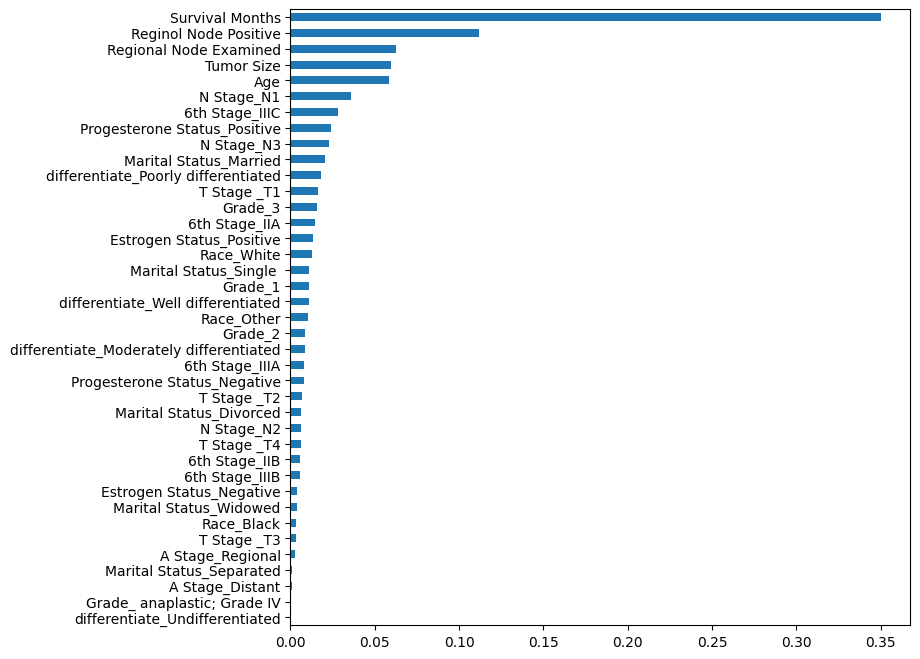

In [1072]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Neural Network

In [1073]:
sizes = [2*i for i in range(1,3)]
sizes = sizes + [[2*i,2*i] for i in range(1,3)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,3)]

print(len(sizes), sizes)


decays = [0.01,0.1,1]
print(len(decays), decays[:10])

6 [2, 4, [2, 2], [4, 4], [2, 2, 2], [4, 4, 4]]
3 [0.01, 0.1, 1]


In [1074]:
from sklearn.neural_network import MLPClassifier


model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0,
                           activation='logistic',
                           max_iter=100000,
                           solver='lbfgs',random_state=42)


trc = GridSearchCV(estimator=model_nnet,
                   scoring=['accuracy', 'f1', 'precision', 'recall', 'jaccard'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays},
                   cv=5,
                   return_train_score=True,
                   refit='recall')


# Fit the GridSearchCV object to the data
trc.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", trc.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", trc.best_score_)

# Get the best model found by GridSearchCV
best_mlpmodel = trc.best_estimator_

c:\Users\nikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': [4, 4]}
Best Score: 0.9566066234056836


In [1075]:
y_pred_mlp = best_mlpmodel.predict(X_val)
results_df.loc['MLP', :] = compute_metrics(y_val, y_pred_mlp)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.768634,0.514658,0.379808,0.79798,0.346491
KNN-5,0.687888,0.417391,0.292683,0.727273,0.263736
Random Forest,0.821429,0.54902,0.448718,0.707071,0.378378
LDA,0.840062,0.569038,0.485714,0.686869,0.397661
MLP,0.785714,0.488889,0.385965,0.666667,0.323529


In [1076]:
# Confusion Matrix
confusion(y_val, y_pred_mlp)

predicted,0,1
target,,
0,440,105
1,33,66


## Generalization Performance

In [1077]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [1078]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7677018633540372
recall_score:  0.7479674796747967
jaccard_score:  0.32974910394265233
f1_score:  0.49595687331536387
precision_score:  0.3709677419354839
